In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rate_card = pd.read_excel('Rate card.xlsx', index_col=None, header=1,na_filter=True).drop(columns=['Unnamed: 5','Year.1'])
rate_card=rate_card.rename(columns={"Year": "Join_year"})
rate_card=rate_card.rename(columns={"Flexible": "Flexible_client", "Standard": "Standard_client"})
rate_card=rate_card.rename(columns={"Join Fee": "Join_Fee_client", "Day Pass": "Day_Pass_com"})
rate_card=rate_card.rename(columns={"Flexible.1": "Flexible_competitor", "Standard.1": "Standard_competitor","Join Fee.1":"Join_fee_competitor"})
rate_card.head()

,Join_year,Flexible_client,Standard_client,Join_Fee_client,Day_Pass_com,Flexible_competitor,Standard_competitor,Join_fee_competitor
0,2009,25.99,20.99,5,6,35.99,30.99,8
1,2010,25.99,20.99,5,6,35.99,30.99,8
2,2011,25.99,20.99,5,6,35.99,30.99,8
3,2012,25.99,20.99,5,6,35.99,30.99,8
4,2013,25.99,20.99,5,6,35.99,30.99,8


In [3]:
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv') 

In [4]:
#convert the join and end date to_date
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [5]:
date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')

In [6]:
##we need to know each month kow many activemembers we have to calculate the churn 
##create the dataframe to help us calculate it
customers_total = pd.DataFrame({'Date':dates})
customers_total.head(), customers_total.shape

(        Date
 0 2009-05-01
 1 2009-06-01
 2 2009-07-01
 3 2009-08-01
 4 2009-09-01,
 (116, 1))

In [7]:
##add total month membership in dataframe subscriptions
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )

In [8]:
##add total month membership in dataframe subscriptions
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
##convert the difference in months
subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7


In [9]:
# What happened when the price was increased, revenue plot over time
## First count the number of member joined every month
member_joined_data = subscriptions.groupby(['Join Date','Subscription Type']).size().reset_index(name='Number_of_member_joined')
member_joined_data=member_joined_data.rename(columns={'Join Date': "Date"})
member_joined_data.head()

,Date,Subscription Type,Number_of_member_joined
0,2009-05-01,Flexible,167
1,2009-05-01,Standard,532
2,2009-06-01,Flexible,124
3,2009-06-01,Standard,428
4,2009-07-01,Flexible,266


In [10]:
## Second count the number of member left every month
member_left_data = subscriptions.groupby(['End Date','Subscription Type']).size().reset_index(name='Number_of_member_left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_left_data.head()


,Date,Subscription Type,Number_of_member_left
0,2009-06-01,Flexible,47
1,2009-06-01,Standard,1
2,2009-07-01,Flexible,52
3,2009-07-01,Standard,4
4,2009-08-01,Flexible,135


In [11]:
### Merge two table and calculate the number of member
member_data = pd.merge(member_joined_data,member_left_data,on = ['Subscription Type','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['net_member'] = member_data['Number_of_member_joined'] - member_data['Number_of_member_left'] 
member_data = member_data.drop(columns = ['Number_of_member_joined', 'Number_of_member_left'])
member_data.head()

,Date,Subscription Type,net_member
0,2009-05-01,Flexible,167.0
1,2009-05-01,Standard,532.0
2,2009-06-01,Flexible,77.0
3,2009-06-01,Standard,427.0
4,2009-07-01,Flexible,214.0


In [16]:
# Calculate the cumulative members without seperating the subscription type
Cumulative_Members = pd.DataFrame(member_data.groupby(['Date']).sum('net_member').unstack(fill_value=0))
Cumulative_Members = Cumulative_Members.rename(columns={0: "Cumulative_members"})
Cumulative_Members = Cumulative_Members.cumsum().reset_index()
Cumulative_Members.head()

,level_0,Date,Cumulative_members
0,net_member,2009-05-01,699.0
1,net_member,2009-06-01,1203.0
2,net_member,2009-07-01,2334.0
3,net_member,2009-08-01,3082.0
4,net_member,2009-09-01,3714.0


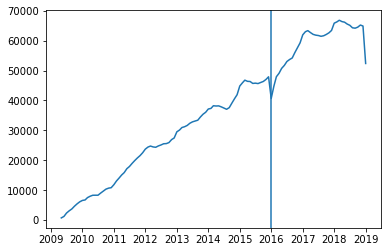

In [17]:
# Plot the graph of cumulative members without seperating the subscription type
plt.plot(Cumulative_Members.Date,Cumulative_Members.Cumulative_members)
plt.axvline(x='2016-01-01')

In [43]:
# Calculate the cumulative members seperating the subscription type
Cumulative_Members_seperating = pd.DataFrame(member_data.groupby(['Date','Subscription Type']).sum('net_member').unstack(fill_value=0))
Cumulative_Members_seperating = Cumulative_Members_seperating.rename(columns={0: "Cumulative_members"})
Cumulative_Members_seperating = Cumulative_Members_seperating.cumsum().reset_index()
x = Cumulative_Members_seperating['net_member']
y = pd.DataFrame({'Date':Cumulative_Members_seperating['Date']})
y['Flexible']=x['Flexible']
y['Standard']=x['Standard']
Cumulative_Members_seperating=y
Cumulative_Members_seperating.head()

,Date,Flexible,Standard
0,2009-05-01,167.0,532.0
1,2009-06-01,244.0,959.0
2,2009-07-01,458.0,1876.0
3,2009-08-01,536.0,2546.0
4,2009-09-01,632.0,3082.0


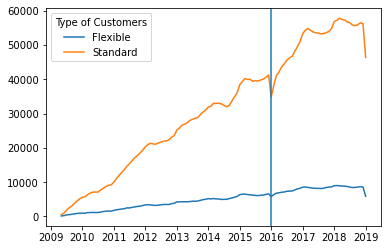

In [48]:
# Plot the graph of cumulative members with seperating the subscription type
Date = Cumulative_Members_seperating['Date']
Flexible = Cumulative_Members_seperating['Flexible']
Standard = Cumulative_Members_seperating['Standard']
plt.plot(Date,Flexible,label='Flexible')
plt.plot(Date,Standard,label='Standard')
plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

In [50]:
# Group visitation_part1 by peak visit or not
visitation_part1_peakvisit = visitation_part1.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_part1_peakvisit.head()

peakvisits,False,True
CustomerID,,
1,11,9
5,18,23
7,64,36
9,26,31
11,75,108


In [51]:
visitation_part2_peakvisit = visitation_part2.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_part2_peakvisit.head()

peakvisits,False,True
CustomerID,,
2,33,41
3,55,110
4,20,32
5,12,40
6,29,10


In [52]:
# Combine Group visitation_part1 and Group visitation_part2
visitation_peakvisit = pd.merge(visitation_part1_peakvisit,visitation_part2_peakvisit,on='CustomerID',how='outer').sort_index().replace({np.nan:0})
visitation_peakvisit.head()

peakvisits,False_x,True_x,False_y,True_y
CustomerID,,,,
1,11.0,9.0,0.0,0.0
2,0.0,0.0,33.0,41.0
3,0.0,0.0,55.0,110.0
4,0.0,0.0,20.0,32.0
5,18.0,23.0,12.0,40.0


In [53]:
# Merge False column and True column, and drop unnecessary columns
visitation_peakvisit['False'] = visitation_peakvisit['False_x'] + visitation_peakvisit['False_y']
visitation_peakvisit['True'] = visitation_peakvisit['True_x'] + visitation_peakvisit['True_y']
visitation_peakvisit=visitation_peakvisit.drop(columns=['False_x','True_x','False_y','True_y'])
visitation_peakvisit.head()

peakvisits,False,True
CustomerID,,
1,11.0,9.0
2,33.0,41.0
3,55.0,110.0
4,20.0,32.0
5,30.0,63.0


In [54]:
# Calculate the proportion of peak time and offpeak time
visitation_peakvisit['Peak_proportion'] = visitation_peakvisit['True']/(visitation_peakvisit['True'] + visitation_peakvisit['False'])

visitation_peakvisit.head()

peakvisits,False,True,Peak_proportion
CustomerID,,,
1,11.0,9.0,0.450000
2,33.0,41.0,0.554054
3,55.0,110.0,0.666667
4,20.0,32.0,0.615385
5,30.0,63.0,0.677419


In [55]:
def classify_peak(Peak_proportion):
    if Peak_proportion < 0.35:
        return 'Off_Peak_Customer'
    elif 0.25 <= Peak_proportion < 0.65:
        return 'Average'
    else:
        return 'Peak_Customer'

In [56]:
# Create three categories according to the peak proportion
visitation_peakvisit['Peak_categogy'] = visitation_peakvisit['Peak_proportion'].apply(lambda x : classify_peak(x))
visitation_peakvisit.head()

peakvisits,False,True,Peak_proportion,Peak_categogy
CustomerID,,,,
1,11.0,9.0,0.450000,Average
2,33.0,41.0,0.554054,Average
3,55.0,110.0,0.666667,Peak_Customer
4,20.0,32.0,0.615385,Average
5,30.0,63.0,0.677419,Peak_Customer


In [57]:
# Merge the subscriptions table and the peak category. The primary key is the CustomerID
subscriptions_with_peak = pd.merge(subscriptions,visitation_peakvisit['Peak_categogy'],on='CustomerID',how='outer')
subscriptions_with_peak.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration,Peak_categogy
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0,Average
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6,Average
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7,Peak_Customer
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2,Average
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7,Peak_Customer


In [58]:
def classify_type_of_customer(Duration):
    if Duration <= 3:
        return 'spur_of_the_moment'
    elif 3 <= Duration < 12:
        return 'normal_customer'
    else:
        return 'loyalty_customer'

In [59]:
# Define the type of a customer
subscriptions_with_peak['Type_of_Customer'] = subscriptions_with_peak['Duration'].apply(lambda x : classify_type_of_customer(x))
u = subscriptions_with_peak.select_dtypes(include=['datetime'])
subscriptions_with_peak[u.columns] = u.fillna(date_max)
subscriptions_with_peak.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration,Peak_categogy,Type_of_Customer
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0,Average,spur_of_the_moment
1,Greenwich,2018-06-01,A,Female,Standard,2018-12-01,2,1972,2018,6,Average,normal_customer
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7,Peak_Customer,normal_customer
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2,Average,spur_of_the_moment
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7,Peak_Customer,normal_customer


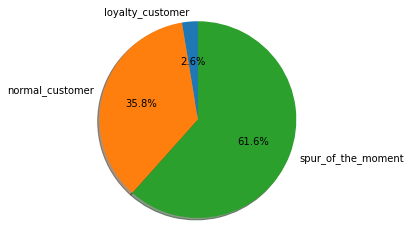

Type_of_Customer
loyalty_customer       22228
normal_customer       304157
spur_of_the_moment    523648
dtype: int64

In [60]:
# Count the size of each group based on the type of customer
data = subscriptions_with_peak.groupby(['Type_of_Customer']).size()
labels = ['loyalty_customer','normal_customer','spur_of_the_moment']
fig1, ax1 = plt.subplots()
ax1.pie(data,labels = labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
data

In [61]:
def calculate_payment(Join_Date,End_Date,Duration):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Join_Date < date_while_price_changed and End_Date < date_while_price_changed:
        return Duration * 25.99 + 5
    elif Join_Date > date_while_price_changed and End_Date > date_while_price_changed:
        return Duration * 30.99 + 5
    elif Join_Date < date_while_price_changed and End_Date > date_while_price_changed:
        fee_1 = round((date_while_price_changed-Join_Date).days/30) * 25.99
        fee_2 = round((End_Date-date_while_price_changed).days/30) * 30.99	
        return fee_1 + fee_2 + 5

In [64]:
# Calculate the charged fee of each customer
data = subscriptions_with_peak.apply(lambda row: calculate_payment(row['Join Date'], row['End Date'],row['Duration']),axis=1)
y = pd.DataFrame(data)
subscriptions_with_peak = pd.merge(subscriptions_with_peak, y, left_index=True, right_index=True)
subscriptions_with_peak = subscriptions_with_peak.rename(columns={0: "Charged_fee"})
subscriptions_with_peak.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration,Peak_categogy,Type_of_Customer,Charged_fee
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0,Average,spur_of_the_moment,5.00
1,Greenwich,2018-06-01,A,Female,Standard,2018-12-01,2,1972,2018,6,Average,normal_customer,190.94
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7,Peak_Customer,normal_customer,221.93
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2,Average,spur_of_the_moment,56.98
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7,Peak_Customer,normal_customer,186.93


In [65]:
# Calculate the fee charged based on the type of customer
data = subscriptions_with_peak_fee.groupby(['Type_of_Customer'])['Charged_fee'].sum()
labels = ['loyalty_customer','normal_customer','spur_of_the_moment']
fig1, ax1 = plt.subplots()
ax1.pie(data,labels = labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
data

NameError: name 'subscriptions_with_peak_fee' is not defined

In [ ]:
# What happened when the price was increased, revenue plot over time
subscriptions_with_peak_fee[['col1', 'col2', 'col3', 'col4']].groupby(['col1', 'col2']).agg(['mean', 'count'])